In [1]:
import os
import pickle
import sys
import time

import numpy as np
from pprint import pprint
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
from lenstronomy.Util import data_util
from lenstronomy.SimulationAPI.ObservationConfig.Roman import Roman
from hydra import initialize, compose
from pyHalo.preset_models import CDM
from pyHalo.plotting_routines import plot_multiplane_convergence

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):  # ../../
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import *
from mejiro.lenses import lens_util
from mejiro.utils import util

In [2]:
# lens = OldSampleStrongLens()
lens = SampleStrongLens()

z_lens = round(lens.z_lens, 2)
z_source = round(lens.z_source, 2)

# log_m_host = np.log10(lens.main_halo_mass)
log_m_host = 11
r_tidal = 0.5
sigma_sub = 0.055

subhalo_cone = 10.
los_normalization = 0.

from astropy.cosmology import default_cosmology
cosmo = default_cosmology.get()
kwargs_cosmo = {'H0': cosmo.H0.value, 'Ob0': cosmo.Ob0, 'Om0': cosmo.Om0}
pprint(kwargs_cosmo)

{'H0': 67.66, 'Ob0': 0.04897, 'Om0': 0.30966}


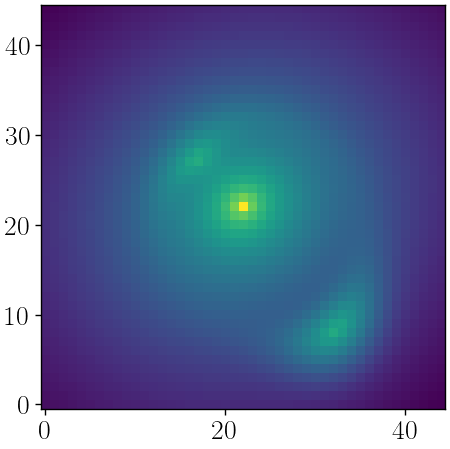

In [46]:
array = lens.get_array(45, 4.95, 'F106')

plt.imshow(np.log10(array))
plt.show()

In [47]:
kwargs_cosmo = util.get_kwargs_cosmo(cosmo)
pprint(kwargs_cosmo)

{'H0': 67.66, 'Ob0': 0.04897, 'Om0': 0.30966}


In [48]:
cut_8_good = False
i = 0

while not cut_8_good:
    cdm_realization = CDM(z_lens,
                z_source,
                sigma_sub=sigma_sub,
                log_mlow=6.,
                log_mhigh=10.,
                log_m_host=log_m_host,
                r_tidal=r_tidal,
                cone_opening_angle_arcsec=subhalo_cone,
                LOS_normalization=los_normalization)
    cut_8_good = lens_util.check_halo_image_alignment(lens, cdm_realization)
    i += 1
print(f'Generated subhalo population after {i} iterations.')

Generated subhalo population after 149 iterations.


In [49]:
print(f'Realization contains {len(cdm_realization.halos)} halos.')

# pickle it
util.pickle(os.path.join(pickle_dir, 'cdm_subhalos_for_sample.pkl'), cdm_realization)

Realization contains 604 halos.


In [3]:
# unpickle to reproduce plots
cdm_realization = util.unpickle(os.path.join(pickle_dir, 'cdm_subhalos_for_sample.pkl'))

print(f'Realization contains {len(cdm_realization.halos)} halos.')

Realization contains 604 halos.


Exception: Cosmology is not set.

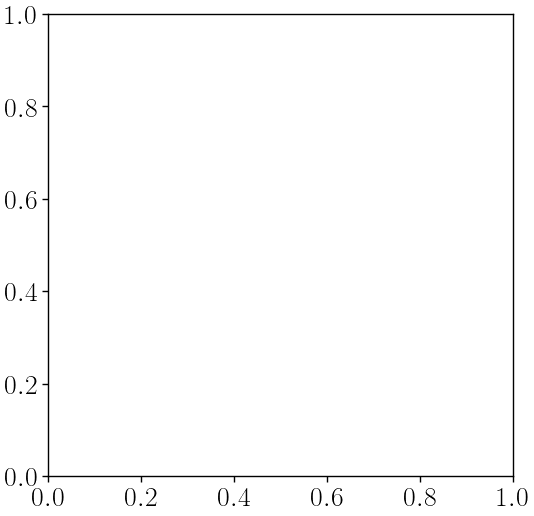

In [4]:
plot_multiplane_convergence(cdm_realization, 
                                  npix=60,
                             cone_opening_angle_arcsec=subhalo_cone, 
                             lens_model_list_macro=None, 
                             kwargs_lens_macro=None, 
                             redshift_list_macro=None,
                                 show_critical_curve=False,
                                 vmin_max=0.01)

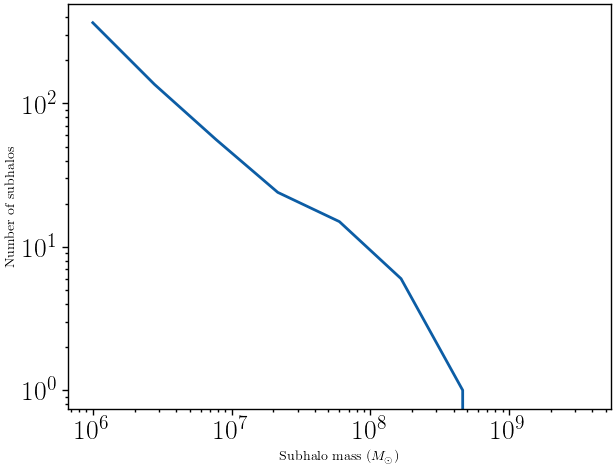

In [ ]:
cdm_halo_masses = [halo.mass for halo in cdm_realization.halos]
N, m = np.histogram(cdm_halo_masses, bins=np.logspace(6, 10, 10))

plt.loglog(m[0:-1], N)
plt.xlabel('Subhalo mass ('+r'$M_{\odot}$)')
plt.ylabel('Number of subhalos')

plt.savefig(os.path.join(figure_dir, 'shmf.png'))
plt.show()

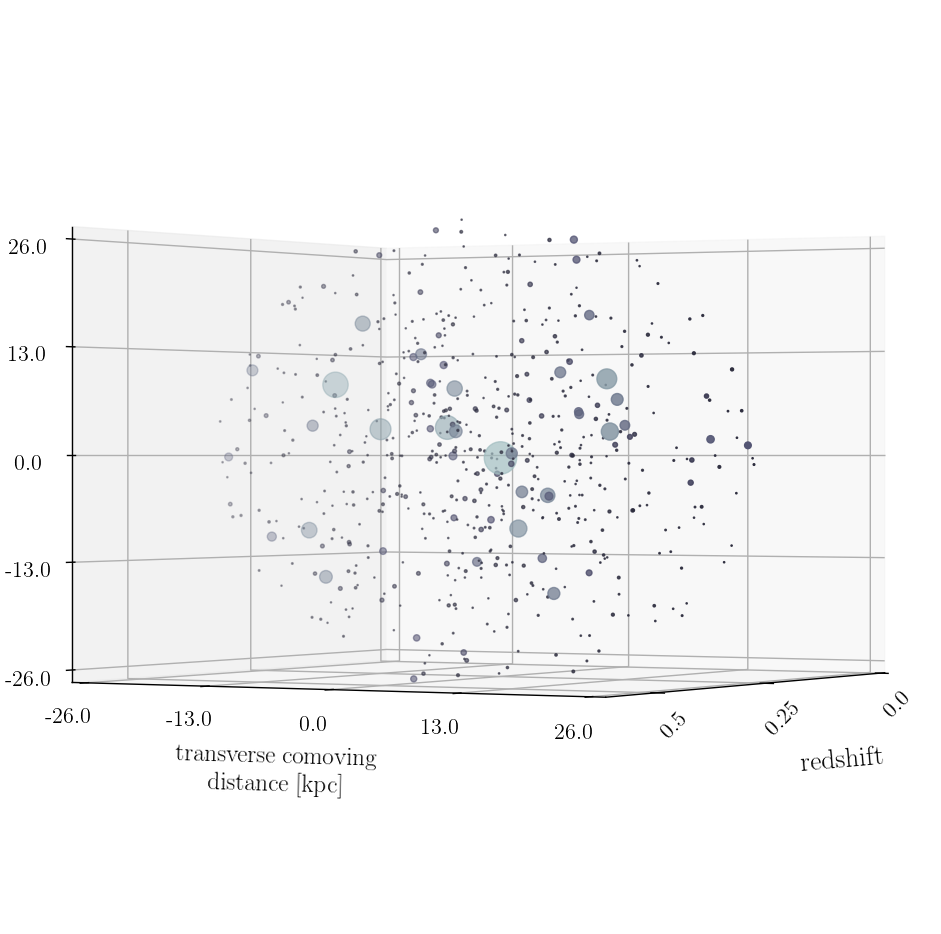

In [8]:
fig = plt.figure(2)
fig.set_size_inches(14,12)
ax = plt.subplot(111, projection='3d')
cdm_realization.plot(ax, view_init_1=0, view_init_2=30)

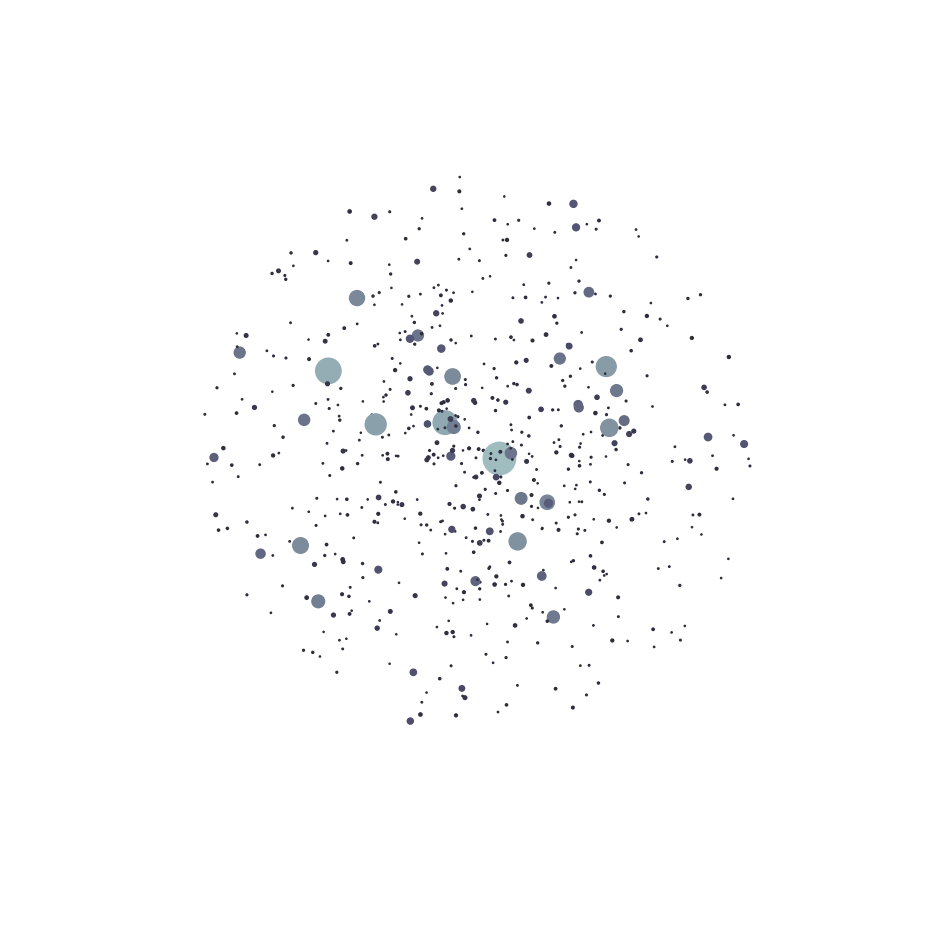

In [ ]:
fig = plt.figure(2)
fig.set_size_inches(14,12)
ax = plt.subplot(111, projection='3d')
cdm_realization.plot(ax, view_init_1=0., view_init_2=0.)
ax.set_axis_off()
ax.set_aspect('equalyz')

In [ ]:
print(cdm_realization.astropy_instance)

FlatLambdaCDM(H0=67.5 km / (Mpc s), Om0=0.309, Tcmb0=0.0 K, Neff=3.04, m_nu=None, Ob0=0.049)


In [ ]:
print(default_cosmology.get())

FlatLambdaCDM(name="Planck18", H0=67.66 km / (Mpc s), Om0=0.30966, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0.   0.   0.06] eV, Ob0=0.04897)


In [ ]:
stats = lens.add_subhalos(cdm_realization, return_stats=True)

pprint(stats)

{'adjusted_einstein_radius': 1.165687426110277,
 'adjusted_lensing_mass': 430128881695.90356,
 'effective_lensing_mass': 431898205024.59985,
 'original_einstein_radius': 1.168082477232392,
 'percent_change_einstein_radius': 0.20504126795820526,
 'percent_change_lensing_mass': 0.4096621167007427,
 'percent_subhalo_mass_within_einstein_radius': 25.88759919526324,
 'total_mass_subhalos_within_einstein_radius': 1769323328.696314,
 'total_subhalo_mass': 6834636597.047031}


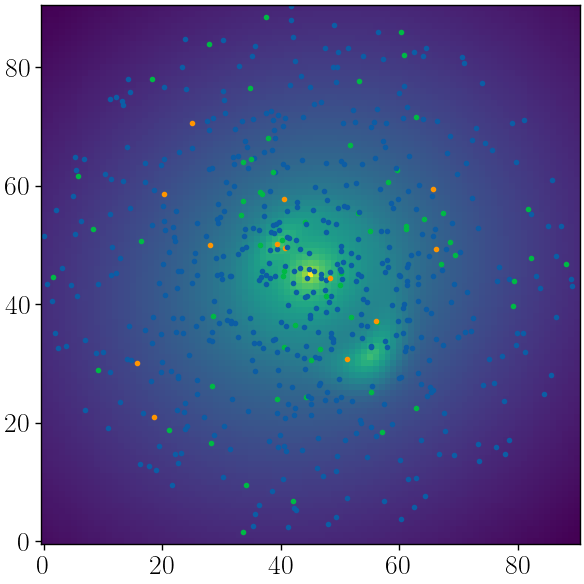

In [ ]:
lens_util.overplot_subhalos(lens)